# LowKey Experiments

## Import


In [19]:
import cv2
import PIL
import torch
import my_utils
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.neighbors import KNeighborsClassifier
from backbone.model_irse import IR_50, IR_101, IR_152
to_tensor = transforms.ToTensor()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# Dataset

In [20]:
# Directories for the face images, attacked face images, and validation face images
face_dir = './facescrub/train'
attack_dir = './facescrub/train_attacked'
val_face_dir = './facescrub/validate'

# Loading data
X, Y = my_utils.get_dataset(face_dir)
X_attacked, Y_attacked = my_utils.get_dataset(attack_dir)
X_test, Y_test = my_utils.get_dataset(val_face_dir)


print("Total number of images: ", len(X))
print("Number of identities: ", len(np.unique(Y)))
print("\nMax number of images per identity: ", max(np.unique(Y, return_counts=True)[1]))
print("Min number of images per identity: ", min(np.unique(Y, return_counts=True)[1]))
print("Mean number of images per identity: ", round(len(X)/len(np.unique(Y)), 2))


Total number of images:  41425
Number of identities:  526

Max number of images per identity:  139
Min number of images per identity:  23
Mean number of images per identity:  78.75


## Comparing the original and attacked images

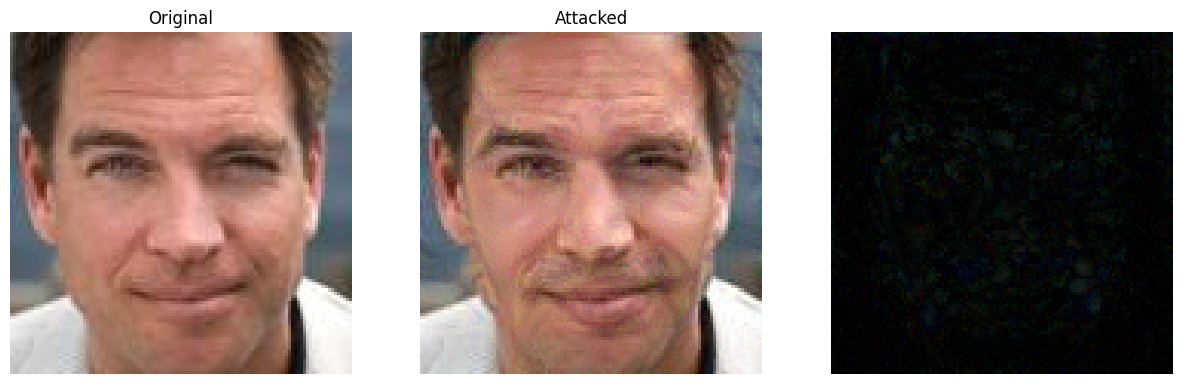

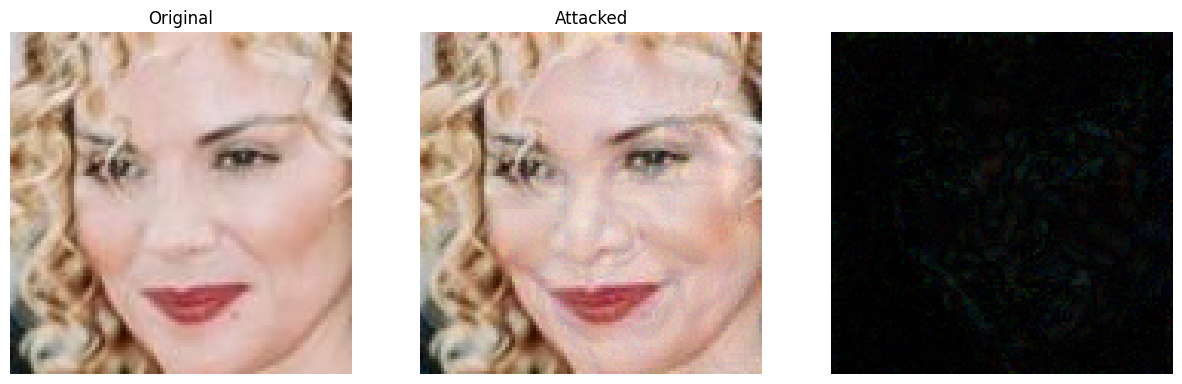

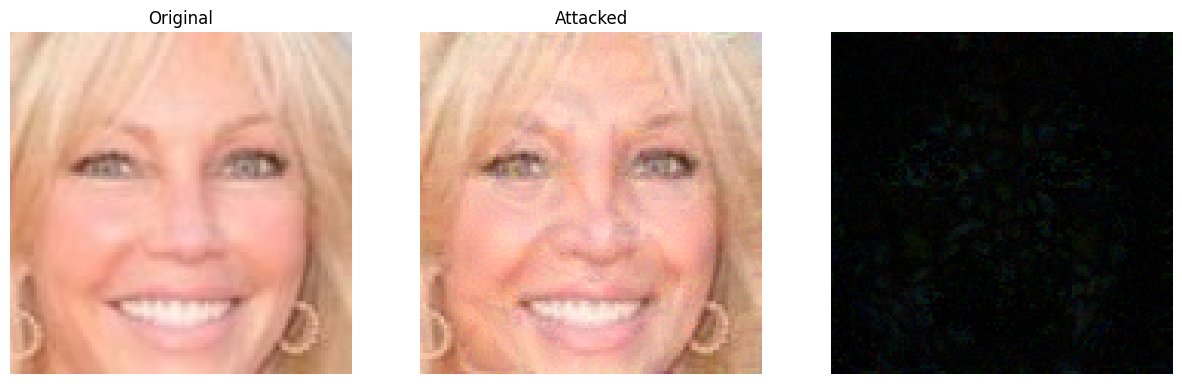

In [21]:
idx = np.random.randint(0, len(X), 3)

for i in range(3):
	face = cv2.imread(X[idx[i]])
	attacked = cv2.imread(X_attacked[idx[i]])
	
	fig, ax = plt.subplots(1, 3, figsize=(15, 15))
	
	for i in range(3):
		ax[i].set_axis_off()

	ax[0].imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
	ax[0].set_title("Original")
	ax[1].imshow(cv2.cvtColor(attacked, cv2.COLOR_BGR2RGB))
	ax[1].set_title("Attacked")

	difference = cv2.absdiff(face, attacked)
	ax[2].imshow(difference)
plt.show()

# Facial recognition

## Models

In [22]:
model_names = ["ir152", "ir152", "resnet_152", "resnet_152", "ir50"]
model_paths = [
    "models/Backbone_IR_152_Arcface_Epoch_112.pth",
    "models/Backbone_IR_152_Cosface_Epoch_70.pth",
    "models/Backbone_ResNet_152_Arcface_Epoch_65.pth",
    "models/Backbone_ResNet_152_Cosface_Epoch_68.pth",
    "models/Backbone_IR50_ms1m_Epoch_120.pth"
]

models = []
for i in range(len(model_names)):
    print("Loading model:", model_names[i], end="...")
    models.append(my_utils.get_model(model_names[i], model_paths[i]).eval().to(device))
    print("Done")

model_names = [ model_paths[i].split("Backbone_")[1].split("_Epoch")[0] for i in range(len(model_paths))]

Loading model: ir152...Done
Loading model: ir152...Done
Loading model: resnet_152...Done
Loading model: resnet_152...Done
Loading model: ir50...Done


In [23]:
# Extracting features
attacked = {}
clean = {}
probe = {}
batch_size = 32

for i in range(len(models)):
    model = model_names[i]
    print("Extracting features for", model, end="...")
    attacked[model] = my_utils.extract_features(models[i], X_attacked, batch_size=batch_size)
    clean[model] = my_utils.extract_features(models[i], X, batch_size=batch_size)
    probe[model] = my_utils.extract_features(models[i], X_test, batch_size=batch_size)   
    print("Done")

Extracting features for IR_152_Arcface...Done
Extracting features for IR_152_Cosface...Done
Extracting features for ResNet_152_Arcface...Done
Extracting features for ResNet_152_Cosface...Done
Extracting features for IR50_ms1m...Done


# Test
For each model:
* Randomly select 100 identities from the FaceScrub dataset. This simulates a small pool of LowKey users among a larger population of non-users.
* Extract features from the original images and the attacked images.
* Compare the features using KNN.

Each test is repeated N times.


In [24]:
accuracies = {}     # Model name -> [[Accuracy for attacked dataset, Accuracy for clean dataset]]
N_test = 20         # Number of tests to run
num_ids = 100       # Number of identities to attack
K = 20              # Number of nearest neighbours to consider

for model in model_names:
    # Testing
    print(end="\n")
    for it in range(N_test):
        # clear output
        print("Model:", model, "- Test:", it+1,"/",N_test, end="\r")

        # Model features
        attacked_features = attacked[model]
        clean_features = clean[model]
        probe_features = probe[model]

        # Gallery preparation
        ids = np.random.choice(np.unique(Y), num_ids, replace=False)
        X_gallery = []    # Gallery images
        Y_victims = set()   # Victim labels

        for j in range(len(Y)):
            if Y[j] in ids:
                X_gallery.append(attacked_features[j])
                Y_victims.add(Y[j])
            else:
                X_gallery.append(clean_features[j])

        # Filtering out probe images on the basis of victim labels
        X_probe = []      # Probe images
        Y_probe = []    # Labels 
        for j in range(len(Y_test)):
            if Y_test[j] in Y_victims:
                X_probe.append(probe_features[j])
                Y_probe.append(Y_test[j])

        # Face recognition
        
        # KNN classifier for attacked dataset
        knn_attacked = KNeighborsClassifier(n_neighbors=K)
        knn_attacked.fit(X_gallery, Y)

        # KNN classifier for clean dataset
        knn_clean = KNeighborsClassifier(n_neighbors=K)
        knn_clean.fit(clean_features, Y)

        # Predictions
        Y_pred_attacked = knn_attacked.predict(X_probe)
        Y_pred_clean = knn_clean.predict(X_probe)

        # Accuracies
        acc_attacked = np.sum(Y_pred_attacked == Y_probe) / len(Y_probe)
        acc_clean = np.sum(Y_pred_clean == Y_probe) / len(Y_probe)

        if model not in accuracies:
            accuracies[model] = []
        accuracies[model].append([acc_attacked, acc_clean])



Model: IR_152_Arcface - Test: 20 / 20
Model: IR_152_Cosface - Test: 20 / 20
Model: ResNet_152_Arcface - Test: 20 / 20
Model: ResNet_152_Cosface - Test: 20 / 20


In [25]:
# Print mean accuracies 
for model in accuracies:
    acc_clean = [ accuracies[model][i][1] for i in range(len(accuracies[model])) ]
    acc_attacked = [ accuracies[model][i][0] for i in range(len(accuracies[model])) ]
    # plot table with accuracies
    print("Model:", model)
    print("Mean accuracy for clean dataset:", round(np.mean(acc_clean), 3))
    print("Mean accuracy for attacked dataset:", round(np.mean(acc_attacked), 3))
    print("")

Model: IR_152_Arcface
Mean accuracy for clean dataset: 0.981
Mean accuracy for attacked dataset: 0.003

Model: IR_152_Cosface
Mean accuracy for clean dataset: 0.971
Mean accuracy for attacked dataset: 0.0

Model: ResNet_152_Arcface
Mean accuracy for clean dataset: 0.964
Mean accuracy for attacked dataset: 0.003

Model: ResNet_152_Cosface
Mean accuracy for clean dataset: 0.956
Mean accuracy for attacked dataset: 0.002

Model: IR50_ms1m
Mean accuracy for clean dataset: 0.97
Mean accuracy for attacked dataset: 0.008



# Mixed Gallery Testing

In [26]:
accuracies = {}     # Model name -> [[Number of clean images, Accuracy for mixed dataset]]
N_clean_images = [1, 2, 3, 5, 7, 10, 15,20]  # Number of clean images to add
num_ids = 100       # Number of identities to attack


for model in model_names:
    print(end="\n")
    for i in range(N_test):
        for n in N_clean_images:
            print("Model:", model, "- Test:", i+1,"/",N_test, "- Clean images:", n, end="\r")

            # Model features
            attacked_features = attacked[model]
            clean_features = clean[model]
            probe_features = probe[model]

            # Gallery preparation
            ids = np.random.choice(np.unique(Y), num_ids, replace=False)
            X_gallery = []    # Gallery images
            Y_victims = {}   # Victim labels

            # For each identity, swap n attacked images with n clean images
            for j in range(len(Y)):
                if Y[j] in ids:
                    if Y[j] not in Y_victims:
                        Y_victims[Y[j]] = 0
                    if Y_victims[Y[j]] < n:
                        X_gallery.append(clean_features[j])
                        Y_victims[Y[j]] += 1
                    else:
                        X_gallery.append(attacked_features[j])
                else:
                    X_gallery.append(clean_features[j])

            # Filtering out probe images on the basis of victim labels
            X_probe = []      # Probe images
            Y_probe = []    # Labels
            for j in range(len(Y_test)):
                if Y_test[j] in Y_victims:
                    X_probe.append(probe_features[j])
                    Y_probe.append(Y_test[j])

            # Face recognition
            knn_mix = KNeighborsClassifier(n_neighbors=K)
            knn_mix.fit(X_gallery, Y)

            # Predictions
            Y_pred_mix = knn_mix.predict(X_probe)

            # Accuracies
            acc_mix = np.sum(Y_pred_mix == Y_probe) / len(Y_probe)

            if model not in accuracies:
                accuracies[model] = []
            accuracies[model].append([n, acc_mix])

Model: IR_152_Arcface - Test: 20 / 20 - Clean images: 20
Model: IR_152_Cosface - Test: 20 / 20 - Clean images: 20
Model: ResNet_152_Arcface - Test: 20 / 20 - Clean images: 20
Model: ResNet_152_Cosface - Test: 20 / 20 - Clean images: 20


In [27]:
# print mean accuracies
for model in accuracies:
    acc_mix = {}
    for i in range(len(accuracies[model])):
        n = accuracies[model][i][0]
        if n not in acc_mix:
            acc_mix[n] = []
        acc_mix[n].append(accuracies[model][i][1])
    print("Model:", model)
    for n in acc_mix:
        print("- Mean acc for", n, "- # clean images:", round(np.mean(acc_mix[n]), 3))
    print("")


Model: IR_152_Arcface
- Mean acc for 1 - # clean images: 0.041
- Mean acc for 2 - # clean images: 0.464
- Mean acc for 3 - # clean images: 0.796
- Mean acc for 5 - # clean images: 0.919
- Mean acc for 7 - # clean images: 0.947
- Mean acc for 10 - # clean images: 0.966
- Mean acc for 15 - # clean images: 0.973
- Mean acc for 20 - # clean images: 0.975

Model: IR_152_Cosface
- Mean acc for 1 - # clean images: 0.009
- Mean acc for 2 - # clean images: 0.215
- Mean acc for 3 - # clean images: 0.332
- Mean acc for 5 - # clean images: 0.445
- Mean acc for 7 - # clean images: 0.666
- Mean acc for 10 - # clean images: 0.852
- Mean acc for 15 - # clean images: 0.932
- Mean acc for 20 - # clean images: 0.947

Model: ResNet_152_Arcface
- Mean acc for 1 - # clean images: 0.038
- Mean acc for 2 - # clean images: 0.407
- Mean acc for 3 - # clean images: 0.704
- Mean acc for 5 - # clean images: 0.85
- Mean acc for 7 - # clean images: 0.888
- Mean acc for 10 - # clean images: 0.916
- Mean acc for 15 - 

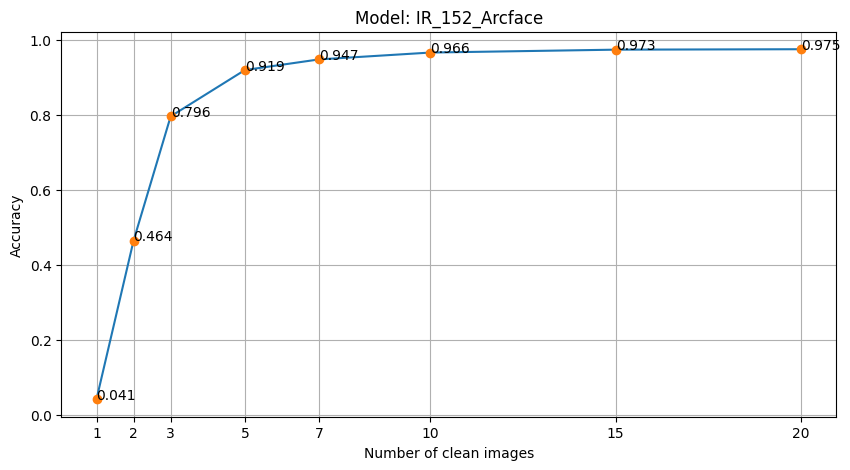

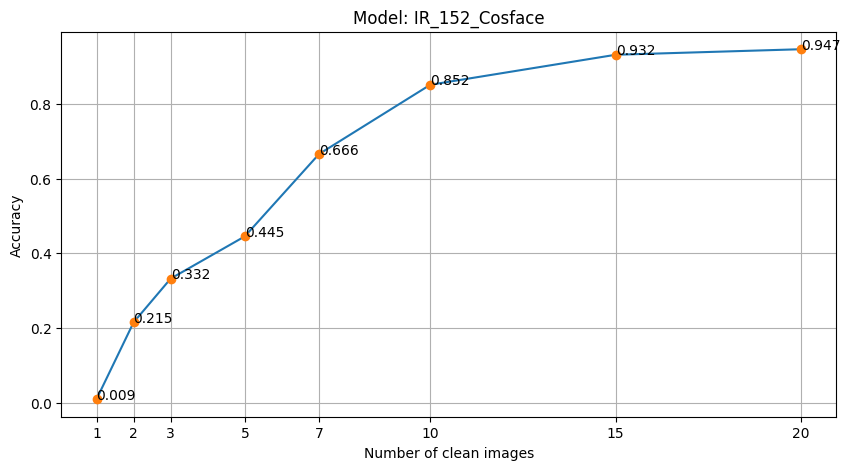

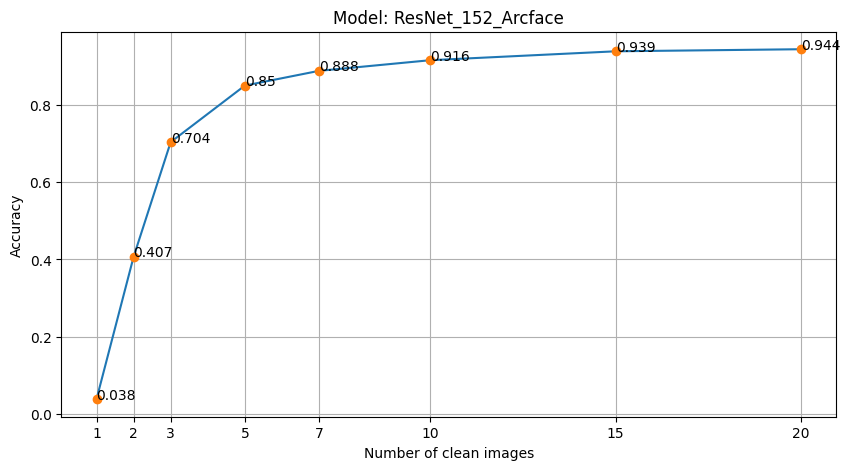

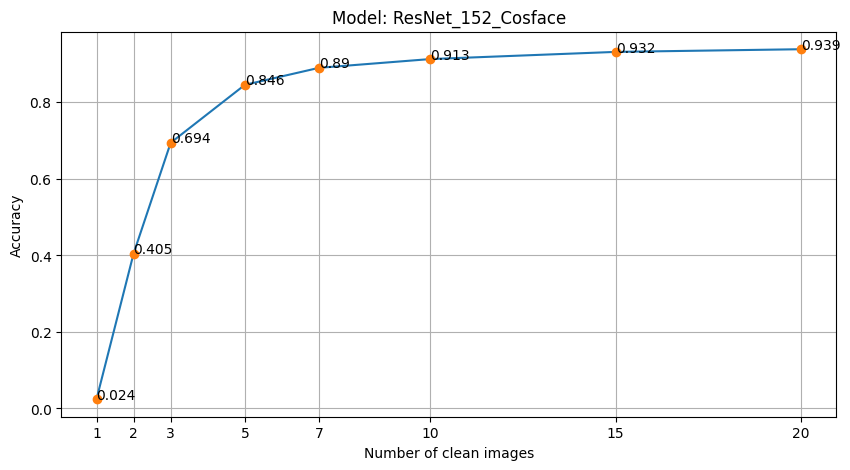

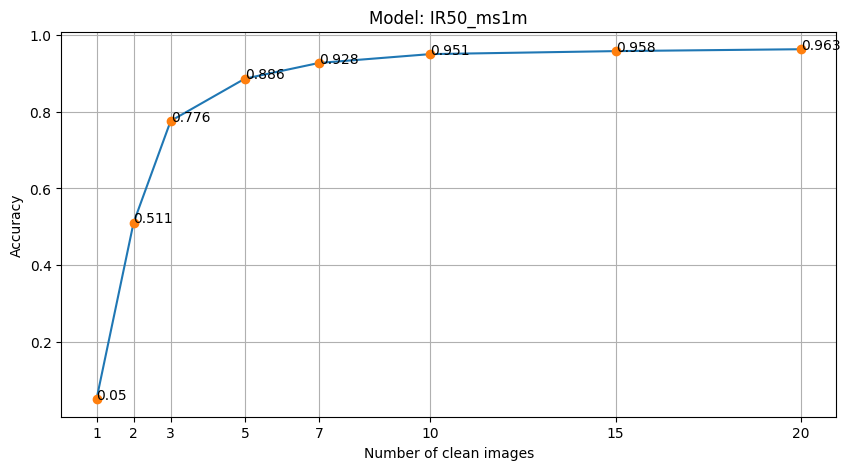

In [28]:
for model, model_accuracies in accuracies.items():
    acc_mix = {}
    for n_clean_images in N_clean_images:
        acc_mix[n_clean_images] = [acc for n, acc in model_accuracies if n == n_clean_images]

    plt.figure(figsize=(10, 5))
    plt.title(f"Model: {model}")
    plt.xlabel("Number of clean images")
    plt.ylabel("Accuracy")
    plt.xticks(N_clean_images)
    for n in N_clean_images:
        plt.text(n, np.mean(acc_mix[n]), round(np.mean(acc_mix[n]), 3))
    plt.plot(N_clean_images, [np.mean(acc_mix[n]) for n in N_clean_images], label="Mixed dataset")
    plt.plot(N_clean_images, [np.mean(acc_mix[n]) for n in N_clean_images], "o")
    plt.grid(True)
    plt.show()